# Project tile: Why predicting Road Accident Severity is difficult - Case study of UK Road Safety 

## Introduction
This project aims to predict the severity of road accidents by using real-world data from UK Road Safety. The dataset contains 34 columns over 2 million rows. Throughout the project, we focus on: 
* **Engineering categorical features**
* **Handling missing values** through systematic imputation
* **Addressing unbalanced classes** using the SMOTENC technique to synthetically generate samples for the minority (non-severe) class
* **Implement and evaluate models**, including Logistic Regression, Random Forest, and XGBoost to evaluate their ability to distinguish between severe and non-severe classes.

### Import packages and load dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTENC
from collections import Counter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [55]:
# Set the 'Accident_Index' column to be index
df = pd.read_csv('Accident_Information.csv', dtype = {'Accident_Index': 'object'}, index_col = 0) 
df.head()

,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
Accident_Index,,,,,,,,,,,,,,,,,,,,,
200501BS00001,A,3218.0,NaN,0.0,Serious,NaN,2005-01-04,Tuesday,1.0,Data missing or out of range,...,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,17:42,Urban,Raining no high winds,2005,No
200501BS00002,B,450.0,C,0.0,Slight,NaN,2005-01-05,Wednesday,1.0,Auto traffic signal,...,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,17:36,Urban,Fine no high winds,2005,No
200501BS00003,C,0.0,NaN,0.0,Slight,NaN,2005-01-06,Thursday,1.0,Data missing or out of range,...,Metropolitan Police,Dry,Single carriageway,NaN,30.0,00:15,Urban,Fine no high winds,2005,No
200501BS00004,A,3220.0,NaN,0.0,Slight,NaN,2005-01-07,Friday,1.0,Data missing or out of range,...,Metropolitan Police,Dry,Single carriageway,NaN,30.0,10:35,Urban,Fine no high winds,2005,No
200501BS00005,Unclassified,0.0,NaN,0.0,Slight,NaN,2005-01-10,Monday,1.0,Data missing or out of range,...,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,21:13,Urban,Fine no high winds,2005,No


## Explorary Data Analysis and Feature Engineering

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2047256 entries, 200501BS00001 to 2017984122617
Data columns (total 33 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   1st_Road_Class                               object 
 1   1st_Road_Number                              float64
 2   2nd_Road_Class                               object 
 3   2nd_Road_Number                              float64
 4   Accident_Severity                            object 
 5   Carriageway_Hazards                          object 
 6   Date                                         object 
 7   Day_of_Week                                  object 
 8   Did_Police_Officer_Attend_Scene_of_Accident  float64
 9   Junction_Control                             object 
 10  Junction_Detail                              object 
 11  Latitude                                     float64
 12  Light_Conditions                             object 
 13 

### Check missing data

In [57]:
df.isnull().sum()

1st_Road_Class                                       0
1st_Road_Number                                      2
2nd_Road_Class                                  844272
2nd_Road_Number                                  17593
Accident_Severity                                    0
Carriageway_Hazards                            2007807
Date                                                 0
Day_of_Week                                          0
Did_Police_Officer_Attend_Scene_of_Accident        278
Junction_Control                                     0
Junction_Detail                                      0
Latitude                                           174
Light_Conditions                                     0
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
Location_Easting_OSGR                              164
Location_Northing_OSGR                             164
Longitude                                          175
LSOA_of_Ac

* Observation: 
Columns '2nd_Road_Class', 'Carriageway_Hazards', and 'Special_Conditions_at_Site' are missing a lot of data. 
* Action: 
Drop them from the DataFrame later on.

### Distribution of the Accident_Severity (target)

<Axes: xlabel='Accident_Severity', ylabel='count'>

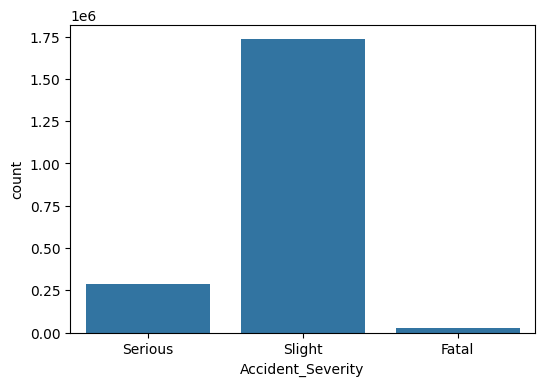

In [58]:
plt.figure(figsize = (6,4))
sns.countplot(data = df, x = 'Accident_Severity')

The target variable 'Accident_Severity' consists of three classes: Slight, Serious, and Fatal. Since the objective of the project is to predict severe accidents, we group 'Serious' and 'Fatal' as 'Severe', and 'Slight' as 'Non-severe'. 

In [59]:
df['Accident_Severity'] = df['Accident_Severity'].replace('Slight', 'Non-severe')
df['Accident_Severity'] = df['Accident_Severity'].replace(['Serious', 'Fatal'], 'Severe')

In [60]:
# Proportions of severe and non-severe accidents
df['Accident_Severity'].value_counts(normalize = True).rename('percentage').reset_index()

,Accident_Severity,percentage
0,Non-severe,0.847255
1,Severe,0.152745


Text(0.5, 1.0, 'Distribution of the target variable')

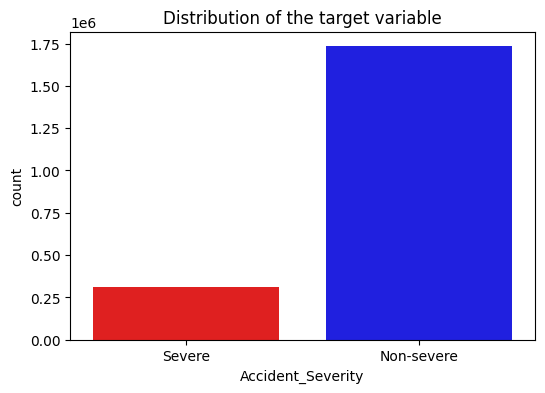

In [61]:
plt.figure(figsize = (6,4))
sns.countplot(data = df, x = 'Accident_Severity', hue = 'Accident_Severity', palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.title('Distribution of the target variable')

* Observation: the target variable is imbalanced, with 85% of the data labeled non-severe and 15% labeled severe.
* Action: later on, apply SMOTE-NC to handle the imbalanced data. 

### Distribution of Day_of_Week

In [62]:
df['Day_of_Week'].value_counts(normalize = True)

Day_of_Week
Friday       0.163723
Wednesday    0.150729
Thursday     0.150563
Tuesday      0.149611
Monday       0.141888
Saturday     0.133423
Sunday       0.110063
Name: proportion, dtype: float64

<Axes: xlabel='Day_of_Week', ylabel='count'>

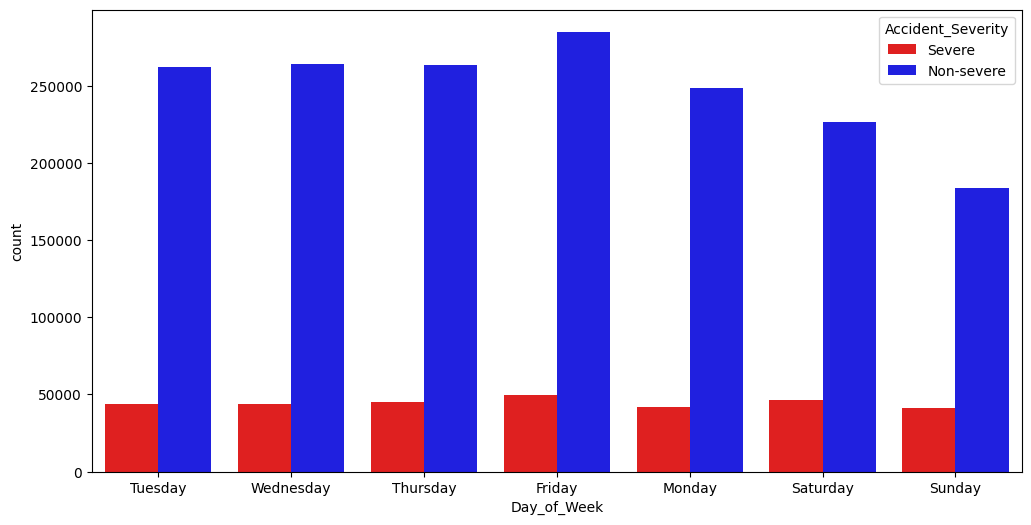

In [63]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'Day_of_Week', hue = 'Accident_Severity', palette = {'Severe': 'red', 'Non-severe': 'blue'})

In [64]:
# Define a function of calculating proportion of severe and non-sever accidents in a feature
def proportion(col):
    grouped = df.groupby([col, 'Accident_Severity']).size().reset_index(name = 'count')
    pivot = grouped.pivot(index = col, columns = 'Accident_Severity', values = 'count')
    percent = pivot.div(pivot.sum(axis = 1), axis = 0) * 100
    print(percent.sort_values(by = 'Severe', ascending = False))

In [65]:
# Proportion of severe and non-severe accidents in 'Day of Week'
proportion('Day_of_Week')

Accident_Severity  Non-severe     Severe
Day_of_Week                             
Sunday              81.567233  18.432767
Saturday            82.975047  17.024953
Friday              85.109328  14.890672
Thursday            85.438944  14.561056
Monday              85.552977  14.447023
Tuesday             85.679678  14.320322
Wednesday           85.725582  14.274418


* Observation: 'Day_of_week' might be an important feature to classify severe and non-severe accidents. Most accidents occurred in weekdays showing similar severity risk. Higher severity risk was observed in the weekend.
* Action: keep it unchanged.

### Distribution of Light_Conditions

In [66]:
df['Light_Conditions'].value_counts(normalize = True)

Light_Conditions
Daylight                        0.730793
Darkness - lights lit           0.197408
Darkness - no lighting          0.055022
Darkness - lighting unknown     0.011900
Darkness - lights unlit         0.004870
Data missing or out of range    0.000007
Name: proportion, dtype: float64

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Daylight'),
  Text(1, 0, 'Darkness - lights lit'),
  Text(2, 0, 'Darkness - lighting unknown'),
  Text(3, 0, 'Darkness - lights unlit'),
  Text(4, 0, 'Darkness - no lighting'),
  Text(5, 0, 'Data missing or out of range')])

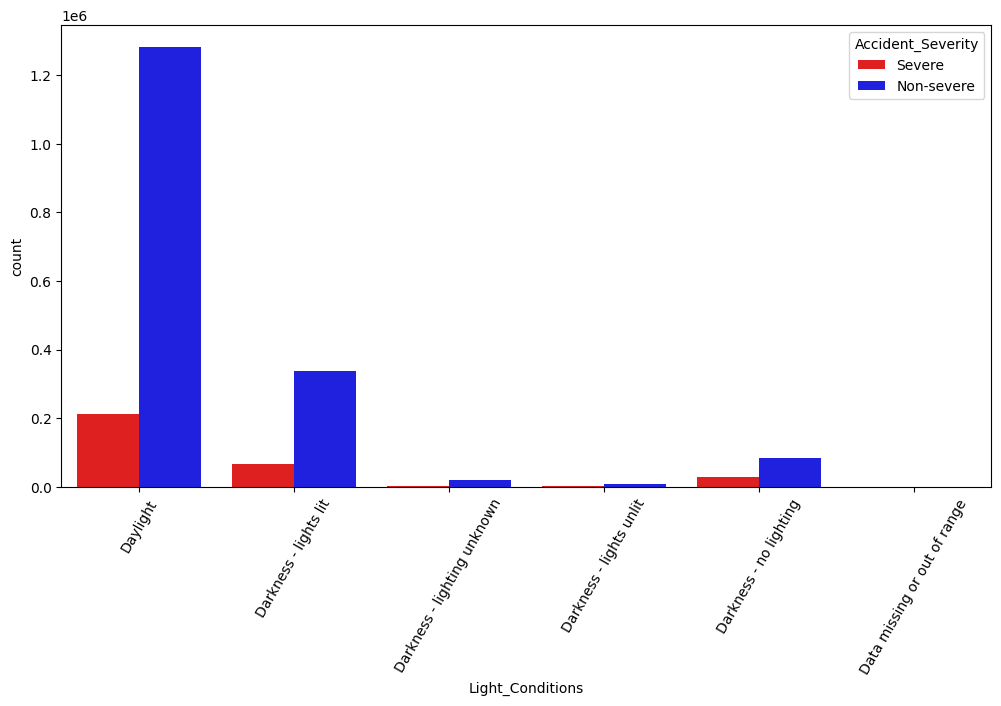

In [67]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'Light_Conditions', hue = 'Accident_Severity', palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.xticks(rotation = 60)

In [68]:
proportion('Light_Conditions')

Accident_Severity             Non-severe     Severe
Light_Conditions                                   
Darkness - no lighting         75.730620  24.269380
Darkness - lights unlit        82.368870  17.631130
Darkness - lights lit          83.436597  16.563403
Darkness - lighting unknown    85.378869  14.621131
Daylight                       85.755898  14.244102
Data missing or out of range   92.857143   7.142857


* Observation: The majority of accidents happened in daylight (73%) likely because the traffic was heavier during the day. However the severity risk by daylight is low (7.14%). Darkness - no lighting accounts for small proportion (5%) but shows the highest severity risk (24.26%).
* Next step:  Group medium risk categories 'Darkness - lights unlit', 'Darkness - lights lit' and 'Darkness - lighting unknown' as 'Darkness - other' while keep 'Darkness - no lighting', 'Daylight' and 'Data missing or out of range' unchanged.

In [69]:
# Feature engineering
df['Light_Conditions'] = df['Light_Conditions'].replace(['Darkness - lights lit', 'Darkness - lights unlit', 'Darkness - lighting unknown'], 'Darkness - other')

In [70]:
proportion('Light_Conditions')

Accident_Severity             Non-severe     Severe
Light_Conditions                                   
Darkness - no lighting         75.730620  24.269380
Darkness - other               83.520230  16.479770
Daylight                       85.755898  14.244102
Data missing or out of range   92.857143   7.142857


### Distribution of Road_Surface_Conditions

In [71]:
df['Road_Surface_Conditions'].value_counts(normalize = True)

Road_Surface_Conditions
Dry                             0.692739
Wet or damp                     0.277720
Frost or ice                    0.019695
Snow                            0.005943
Data missing or out of range    0.002513
Flood over 3cm. deep            0.001390
Name: proportion, dtype: float64

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Wet or damp'),
  Text(1, 0, 'Dry'),
  Text(2, 0, 'Frost or ice'),
  Text(3, 0, 'Snow'),
  Text(4, 0, 'Flood over 3cm. deep'),
  Text(5, 0, 'Data missing or out of range')])

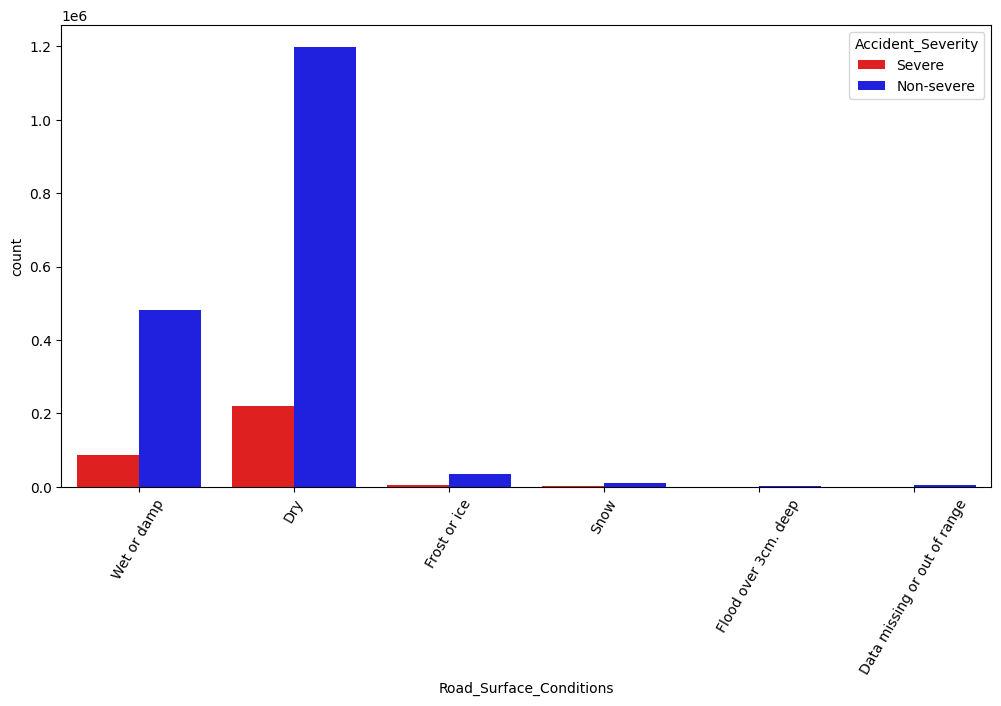

In [72]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'Road_Surface_Conditions', hue = 'Accident_Severity', palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.xticks(rotation = 60)

In [73]:
proportion('Road_Surface_Conditions')

Accident_Severity             Non-severe     Severe
Road_Surface_Conditions                            
Flood over 3cm. deep           84.112478  15.887522
Dry                            84.512644  15.487356
Wet or damp                    84.948722  15.051278
Frost or ice                   86.944768  13.055232
Snow                           89.150982  10.849018
Data missing or out of range   91.214772   8.785228


* Observation: Most accidents occured on dry roads (69.27%), followed by wet or damp (27.77%). Even though 'Flood over 3cm. deep' is a rare category, but shows slighly higher severity risk (15.89%) compared with 'Dry' (15.48%) and 'Wet or damp' (15.05%). 'Frost or ice' and 'Snow' show lower severity risk.
* Next step: Group rare catagories 'Flood over 3cm. deep', 'Frost or ice' and 'Snow' as 'Flood or Slippery' while keep other categories as they are.

In [74]:
df['Road_Surface_Conditions'] = df['Road_Surface_Conditions'].replace(['Flood over 3cm. deep', 'Frost or ice', 'Snow'], 'Flood or Slippery')

In [75]:
proportion('Road_Surface_Conditions')

Accident_Severity             Non-severe     Severe
Road_Surface_Conditions                            
Dry                            84.512644  15.487356
Wet or damp                    84.948722  15.051278
Flood or Slippery              87.284261  12.715739
Data missing or out of range   91.214772   8.785228


### Distribution of Road_Type

In [76]:
df['Road_Type'].value_counts(normalize = True)

Road_Type
Single carriageway              7.463073e-01
Dual carriageway                1.482018e-01
Roundabout                      6.679868e-02
One way street                  2.112975e-02
Slip road                       1.053019e-02
Unknown                         7.031851e-03
Data missing or out of range    4.884587e-07
Name: proportion, dtype: float64

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Single carriageway'),
  Text(1, 0, 'Dual carriageway'),
  Text(2, 0, 'One way street'),
  Text(3, 0, 'Roundabout'),
  Text(4, 0, 'Slip road'),
  Text(5, 0, 'Unknown'),
  Text(6, 0, 'Data missing or out of range')])

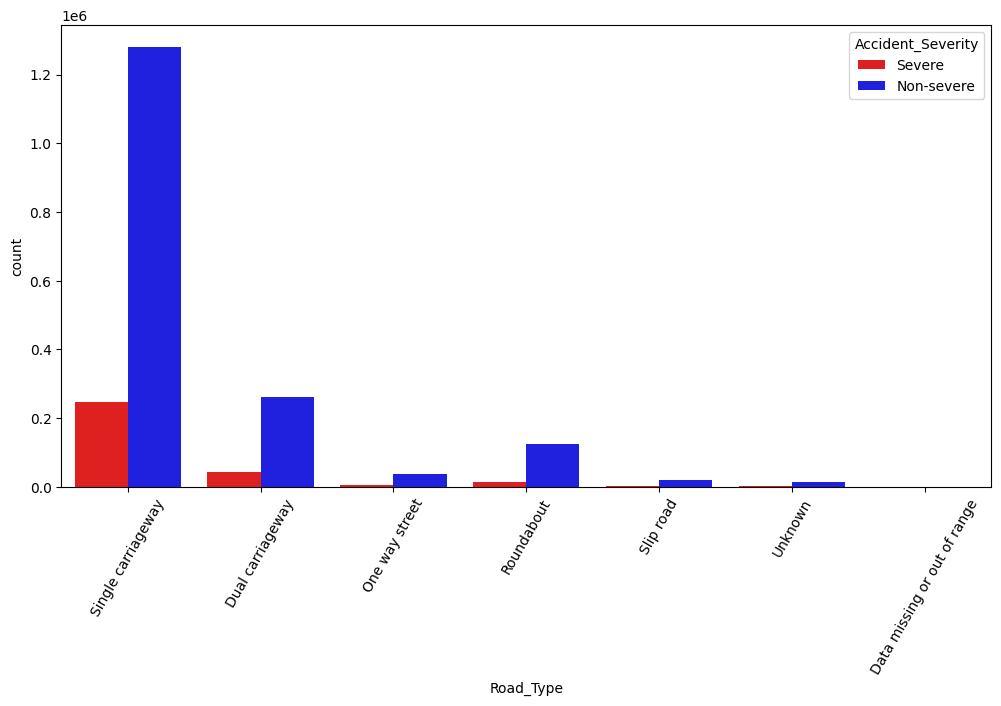

In [77]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'Road_Type', hue = 'Accident_Severity', palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.xticks(rotation = 60)

In [78]:
proportion('Road_Type')

Accident_Severity             Non-severe     Severe
Road_Type                                          
Single carriageway             83.831539  16.168461
Dual carriageway               85.880023  14.119977
One way street                 86.326229  13.673771
Unknown                        88.656571  11.343429
Slip road                      89.934131  10.065869
Roundabout                     90.410518   9.589482
Data missing or out of range  100.000000        NaN


* Observation: Most accidents occured on Single (74.63%) and Dual carriageway (14.82%). These road type also shows the highest severity risk (16.17% and 14.12%). 
* Next step: Group 'One way street', 'Slip road' and 'Roundabout' as 'Low-severity road types' and group 'Unknown' and 'Data missing or out of range' as 'Unknown'.

In [79]:
# Feature Engineering
df['Road_Type'] = df['Road_Type'].replace(['One way street', 'Slip road', 'Roundabout'], 'Low-severity road types')
df['Road_Type'] = df['Road_Type'].replace('Data missing or out of range', 'Unknown')

In [80]:
proportion('Road_Type')

Accident_Severity        Non-severe     Severe
Road_Type                                     
Single carriageway        83.831539  16.168461
Dual carriageway          85.880023  14.119977
Unknown                   88.657359  11.342641
Low-severity road types   89.483058  10.516942


### Distribution of Waether_Conditions

In [81]:
df['Weather_Conditions'].value_counts(normalize = True)

Weather_Conditions
Fine no high winds              0.801119
Raining no high winds           0.116879
Other                           0.021533
Unknown                         0.020770
Raining + high winds            0.013844
Fine + high winds               0.012610
Snowing no high winds           0.006539
Fog or mist                     0.005406
Snowing + high winds            0.001215
Data missing or out of range    0.000085
Name: proportion, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Raining no high winds'),
  Text(1, 0, 'Fine no high winds'),
  Text(2, 0, 'Unknown'),
  Text(3, 0, 'Snowing no high winds'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'Fine + high winds'),
  Text(6, 0, 'Raining + high winds'),
  Text(7, 0, 'Fog or mist'),
  Text(8, 0, 'Snowing + high winds'),
  Text(9, 0, 'Data missing or out of range')])

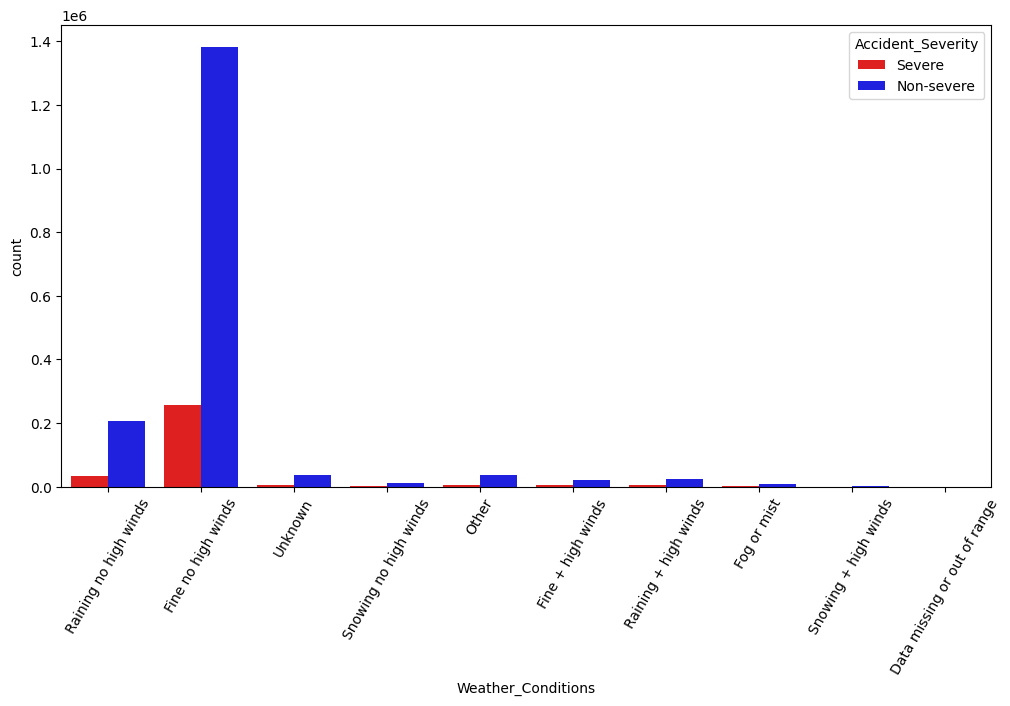

In [82]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'Weather_Conditions', hue = 'Accident_Severity', palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.xticks(rotation = 60)

In [83]:
proportion('Weather_Conditions')

Accident_Severity             Non-severe     Severe
Weather_Conditions                                 
Fine + high winds              82.933065  17.066935
Fog or mist                    83.005060  16.994940
Fine no high winds             84.287008  15.712992
Raining + high winds           84.758141  15.241859
Raining no high winds          86.378776  13.621224
Snowing + high winds           87.535183  12.464817
Other                          87.623347  12.376653
Snowing no high winds          89.108837  10.891163
Unknown                        89.280591  10.719409
Data missing or out of range   89.714286  10.285714


* Observation: Most accidents occurred under a fine condition with no high winds (80.11%). It seemed that high wind and no high wind showed similar severity rates.
* Next step: Check the affect of high wind on the accident severity.

In [84]:
df['High_winds'] = df['Weather_Conditions'].copy() 
df['High_winds'] = df['High_winds'].replace(['Fine + high winds', 'Raining + high winds', 'Snowing + high winds'], 'High winds')
df['High_winds']  = df['High_winds'].replace(['Fine no high winds', 'Raining no high winds', 'Snowing no high winds', 'Fog or mist'], 'No high winds')
df['High_winds'] = df['High_winds'].replace(['Data missing or out of range', 'Other', 'Unknown'], 'Unknown')

proportion('High_winds')

Accident_Severity  Non-severe     Severe
High_winds                              
High winds          84.048300  15.951700
No high winds       84.576362  15.423638
Unknown             88.439599  11.560401


* Observation: The severity rates of 'High winds' and 'No high winds' are almost the same (the difference is 1%). Unknown shows the least severity (11.56%) 
* Next step: 
1. Although the observation suggests that 'High_winds' might be a weak feature, but we will keep it and let SelectKBest method to decide later on.
2.  Ignore the windy condition and group 'Fine + high winds', 'Fine no high winds' as 'Fine', 'Raining no high winds', 'Raining + high winds' as 'Raining', 'Snowing no high winds', 'Snowing + high winds' as 'Snowing', and 'Data missing or out of range', 'Unknown' as 'Unknown' while keep 'Fog or mist' as it is.

In [85]:
df['Weather_Conditions'] = df['Weather_Conditions'].replace(['Fine + high winds', 'Fine no high winds'], 'Fine')
df['Weather_Conditions'] = df['Weather_Conditions'].replace(['Raining no high winds', 'Raining + high winds'], 'Raining')
df['Weather_Conditions'] = df['Weather_Conditions'].replace(['Snowing no high winds', 'Snowing + high winds'], 'Snowing')
df['Weather_Conditions'] = df['Weather_Conditions'].replace(['Data missing or out of range', 'Unknown'], 'Unknown')

In [86]:
proportion('Weather_Conditions')

Accident_Severity   Non-severe     Severe
Weather_Conditions                       
Fog or mist          83.005060  16.994940
Fine                 84.266026  15.733974
Raining              86.207141  13.792859
Other                87.623347  12.376653
Snowing              88.862291  11.137709
Unknown              89.282368  10.717632


### Distribution of Junction_Control

In [87]:
df['Junction_Control'].value_counts(normalize = True)

Junction_Control
Give way or uncontrolled               0.482750
Data missing or out of range           0.368450
Auto traffic signal                    0.103228
Not at junction or within 20 metres    0.037760
Stop sign                              0.006024
Authorised person                      0.001788
Name: proportion, dtype: float64

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Data missing or out of range'),
  Text(1, 0, 'Auto traffic signal'),
  Text(2, 0, 'Give way or uncontrolled'),
  Text(3, 0, 'Stop sign'),
  Text(4, 0, 'Authorised person'),
  Text(5, 0, 'Not at junction or within 20 metres')])

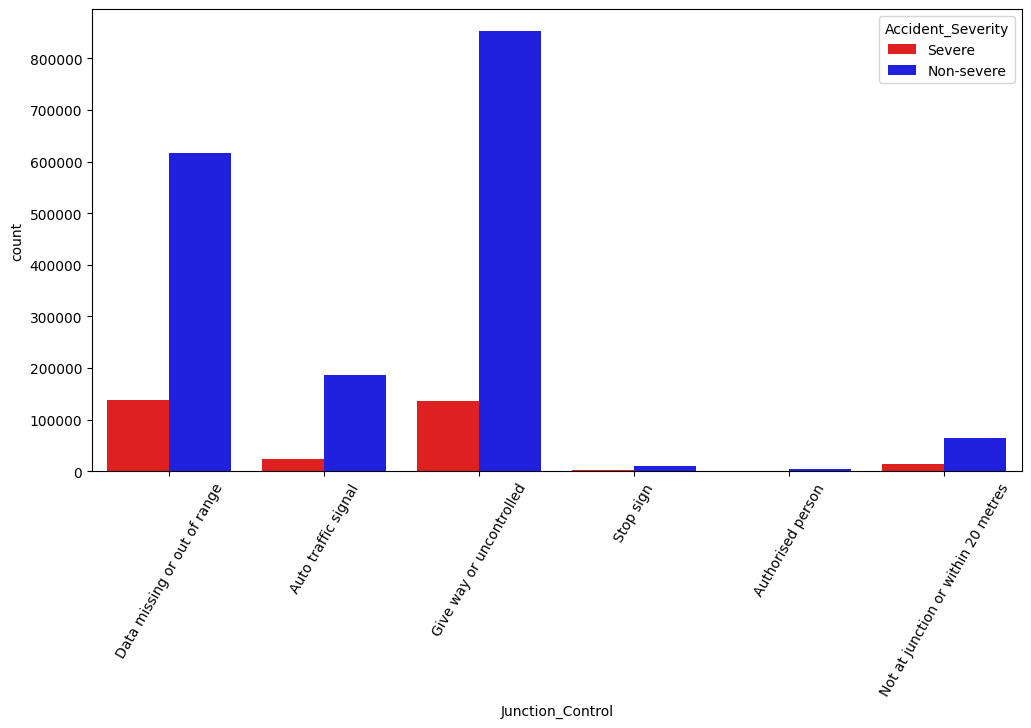

In [88]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'Junction_Control', hue = 'Accident_Severity', palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.xticks(rotation = 60)

In [89]:
proportion('Junction_Control')

Accident_Severity                    Non-severe     Severe
Junction_Control                                          
Data missing or out of range          81.747051  18.252949
Not at junction or within 20 metres   82.614095  17.385905
Give way or uncontrolled              86.280966  13.719034
Authorised person                     87.868852  12.131148
Stop sign                             88.129409  11.870591
Auto traffic signal                   88.601509  11.398491


* Observation: Most accidents happened when there were uncontrolled junctions (48.28%). A lof of data is missing (36.85%). Missing values show the highest severity rate (18.25%), followed by uncontrolled junctions ('Not at junction or within 20 metres': 17.38% and 'Give way or uncontrolled': 13.72%). Controlled junctions ('Authorised person', 'Stop sign', and 'Auto traffic signal') show the least severity rate.
* Next step: Group 'Not at junction or within 20 metres' and 'Give way or uncontrolled' as 'Uncontrolled junctions', and group 'Authorised person', 'Stop sign', and 'Auto traffic signal' as 'Controlled junctions'.

In [90]:
df['Junction_Control'] = df['Junction_Control'].replace(['Not at junction or within 20 metres', 'Give way or uncontrolled'], 'Uncontrolled junctions')
df['Junction_Control'] = df['Junction_Control'].replace(['Authorised person', 'Stop sign', 'Auto traffic signal'], 'Controlled junctions')

In [91]:
proportion('Junction_Control')

Accident_Severity             Non-severe     Severe
Junction_Control                                   
Data missing or out of range   81.747051  18.252949
Uncontrolled junctions         86.014957  13.985043
Controlled junctions           88.564101  11.435899


### Distribution of Junction_Detail

In [92]:
df['Junction_Detail'].value_counts(normalize = True)

Junction_Detail
Not at junction or within 20 metres    0.404064
T or staggered junction                0.310342
Crossroads                             0.095876
Roundabout                             0.086562
Private drive or entrance              0.035536
Other junction                         0.029157
Slip road                              0.014679
More than 4 arms (not roundabout)      0.012481
Mini-roundabout                        0.010945
Data missing or out of range           0.000359
Name: proportion, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Not at junction or within 20 metres'),
  Text(1, 0, 'Crossroads'),
  Text(2, 0, 'T or staggered junction'),
  Text(3, 0, 'Mini-roundabout'),
  Text(4, 0, 'Other junction'),
  Text(5, 0, 'More than 4 arms (not roundabout)'),
  Text(6, 0, 'Private drive or entrance'),
  Text(7, 0, 'Roundabout'),
  Text(8, 0, 'Slip road'),
  Text(9, 0, 'Data missing or out of range')])

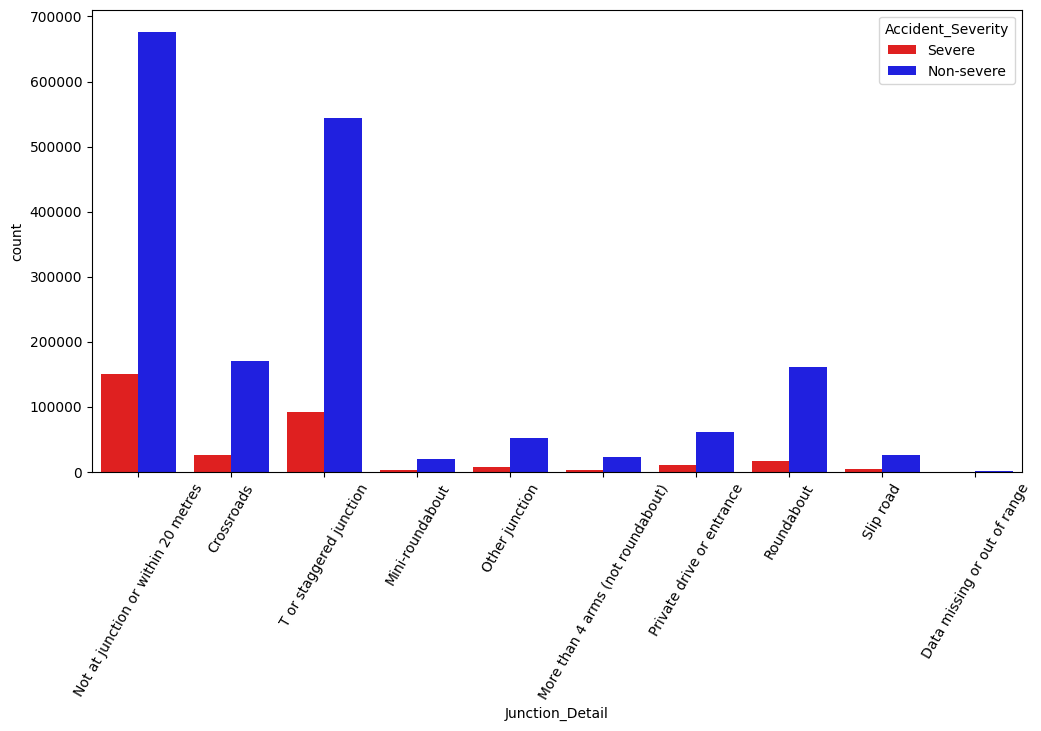

In [93]:
plt.figure(figsize = (12,6))
sns.countplot(data = df, x = 'Junction_Detail', hue = 'Accident_Severity', palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.xticks(rotation = 60)

In [94]:
proportion('Junction_Detail')

Accident_Severity                    Non-severe     Severe
Junction_Detail                                           
Not at junction or within 20 metres   81.781575  18.218425
Private drive or entrance             84.992646  15.007354
T or staggered junction               85.544795  14.455205
Other junction                        86.509080  13.490920
Crossroads                            86.972891  13.027109
Slip road                             87.684680  12.315320
More than 4 arms (not roundabout)     87.687370  12.312630
Mini-roundabout                       89.775517  10.224483
Roundabout                            90.716873   9.283127
Data missing or out of range          95.912807   4.087193


* Observation: Most accidents happened not at junction or within 20 meters (40.41%), followed by at a T or staggered junction (31.03%). 'Not at junction or within 20 metres' shows the highest severity, whereas roundabout shows the lowest severity (mini-roundabout: 10.22% and roundabout: 9.28%).
* Next step: Group categories based on their levels of severity. First, keep 'Not at junction or within 20 metres' as is, then group 'T or staggered junction' and 'Private drive or entrance' as 'T or driveway junction', group 'Mini-roundabout', 'Roundabout' and 'Data missing or out of range' as 'Roundabout or Unknown', and the rest as 'Other junction'.

In [95]:
df['Junction_Detail'] = df['Junction_Detail'].replace(['Private drive or entrance', 'T or staggered junction'], 'T or Driveway junction')
df['Junction_Detail'] = df['Junction_Detail'].replace(['Other junction', 'Crossroads', 'Slip road', 'More than 4 arms (not roundabout)'], 'Other junction')
df['Junction_Detail'] = df['Junction_Detail'].replace(['Mini-roundabout', 'Roundabout', 'Data missing or out of range'], 'Roundabout or Unknown')

In [96]:
proportion('Junction_Detail')

Accident_Severity                    Non-severe     Severe
Junction_Detail                                           
Not at junction or within 20 metres   81.781575  18.218425
T or Driveway junction                85.488067  14.511933
Other junction                        87.011278  12.988722
Roundabout or Unknown                 90.630631   9.369369


### Extract Month from Date

<Axes: xlabel='Month', ylabel='Count'>

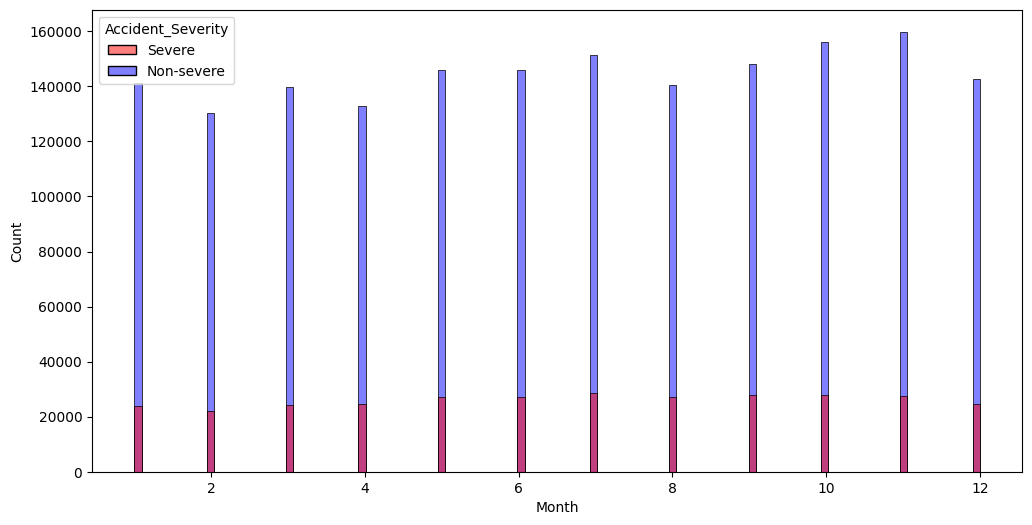

In [97]:
df['Month'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d').dt.month

plt.figure(figsize = (12,6))
sns.histplot(data = df, x = df['Month'], hue = 'Accident_Severity', palette = {'Severe': 'red', 'Non-severe': 'blue'})

In [98]:
proportion('Month')

Accident_Severity  Non-severe     Severe
Month                                   
8                   83.849119  16.150881
7                   84.162446  15.837554
9                   84.188369  15.811631
6                   84.238732  15.761268
5                   84.327780  15.672220
4                   84.463952  15.536048
10                  84.765135  15.234865
3                   85.195430  14.804570
12                  85.241644  14.758356
11                  85.257330  14.742670
1                   85.542169  14.457831
2                   85.591498  14.408502


* Observation: Month is well-distributed. The severity does not change significantly across months. The difference between the highest (August: 16.15%) and the lowest (February: 14.41%) is less than 2%. 
* Action: Even though the observation suggests that Month might be a weak feature, we still keep it and let SelectKBest method to decide later on.

### Extract Hour_of_day from Time

In [99]:
df['Hour_of_day'] = pd.to_datetime(df['Time'], format = '%H:%M').dt.hour
df['Hour_of_day'].value_counts(normalize = True)

Hour_of_day
17.0    0.088848
16.0    0.081102
15.0    0.077196
8.0     0.073020
18.0    0.069570
14.0    0.060684
13.0    0.060328
12.0    0.058756
19.0    0.051879
11.0    0.051627
9.0     0.049447
10.0    0.045183
7.0     0.042452
20.0    0.038093
21.0    0.030399
22.0    0.026482
23.0    0.020995
6.0     0.017875
0.0     0.015181
1.0     0.011111
2.0     0.008811
5.0     0.008237
3.0     0.007155
4.0     0.005569
Name: proportion, dtype: float64

In [100]:
proportion('Hour_of_day')

Accident_Severity  Non-severe     Severe
Hour_of_day                             
2.0                 75.903748  24.096252
3.0                 76.024031  23.975969
4.0                 76.140351  23.859649
1.0                 77.042117  22.957883
0.0                 77.919362  22.080638
5.0                 77.955044  22.044956
23.0                80.160078  19.839922
22.0                81.059195  18.940805
6.0                 81.817933  18.182067
21.0                81.839657  18.160343
20.0                82.839410  17.160590
19.0                83.790324  16.209676
18.0                84.746203  15.253797
16.0                85.092517  14.907483
7.0                 85.302173  14.697827
15.0                85.362721  14.637279
14.0                85.371135  14.628865
17.0                85.380001  14.619999
10.0                85.714749  14.285251
13.0                85.883058  14.116942
11.0                85.999905  14.000095
12.0                86.252796  13.747204
9.0             

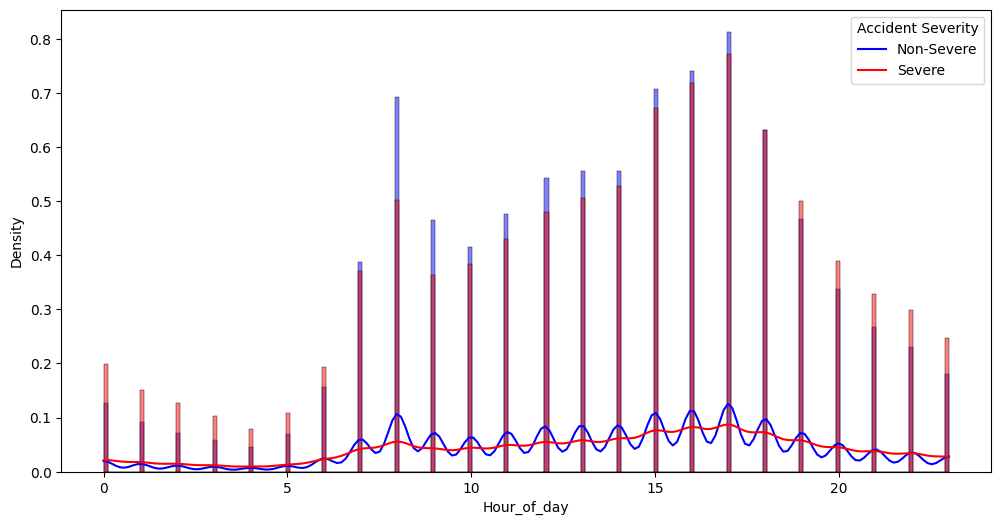

In [101]:
plt.figure(figsize=(12, 6))
sns.histplot(data = df, x = 'Hour_of_day', hue = 'Accident_Severity', kde = True, stat = 'density', common_norm = False, palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.legend(title = 'Accident Severity', labels = ['Non-Severe', 'Severe'])

* Observation: Most accidents occurred during rush hours (15 - 17, 8) and the least happened during nighttime or early morning (0 - 5) as what we expected. However, the severity shows an opposite trend. While early morning (0-5) is the time window showing the highest severity, rush hours (8-9) show the lowest severity.
* Action: keep it unchanged.

### Distribution of Speed_limit

In [102]:
df['Speed_limit'].value_counts(normalize = True)

Speed_limit
30.0    6.380236e-01
60.0    1.550733e-01
40.0    8.223693e-02
70.0    7.195371e-02
50.0    3.393824e-02
20.0    1.875666e-02
10.0    9.280883e-06
15.0    7.815480e-06
0.0     4.884675e-07
Name: proportion, dtype: float64

In [103]:
proportion('Speed_limit')

Accident_Severity  Non-severe     Severe
Speed_limit                             
10.0                73.684211  26.315789
60.0                77.544894  22.455106
50.0                82.489673  17.510327
40.0                84.427140  15.572860
20.0                84.814709  15.185291
70.0                85.269339  14.730661
30.0                86.564041  13.435959
15.0                93.750000   6.250000
0.0                100.000000        NaN


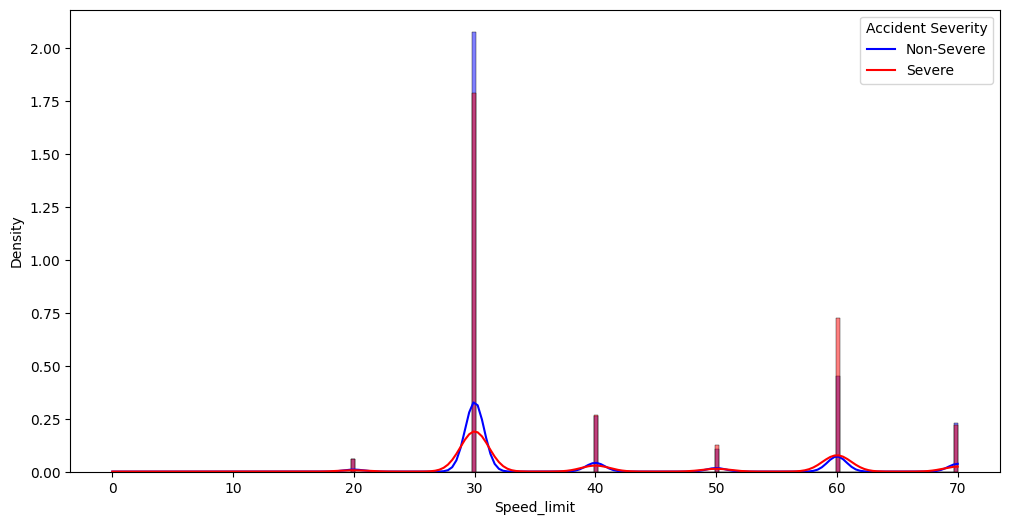

In [104]:
plt.figure(figsize=(12, 6))
sns.histplot(data = df, x = 'Speed_limit', hue = 'Accident_Severity', kde = True, stat = 'density', common_norm = False, palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.legend(title = 'Accident Severity', labels = ['Non-Severe', 'Severe'])

* Observation: Most accidents occurred in the zone 30 (63.80%), but the severity rate is low (13.43%). The second highest number of accidents happened in the zone 60 (15.51%), showing a high severity rate (22.46%). There were not many accidents in the low-speed zones but the severity is likely high. For example, zone 10 shows the highest severity rate (26.32%).
* Action: keep it unchanged.

### Distribution of Number_of_Casualties

In [105]:
df['Number_of_Casualties'].value_counts(normalize = True)

Number_of_Casualties
1     7.701367e-01
2     1.584980e-01
3     4.526254e-02
4     1.628375e-02
5     6.010973e-03
6     2.234699e-03
7     7.654148e-04
8     3.292212e-04
9     1.607029e-04
10    9.280715e-05
11    5.568429e-05
12    3.174982e-05
13    2.442293e-05
14    1.807297e-05
15    1.221147e-05
16    1.074609e-05
17    9.769174e-06
19    7.326880e-06
18    5.861504e-06
21    5.373046e-06
22    5.373046e-06
26    3.907670e-06
29    2.930752e-06
27    2.930752e-06
24    2.442293e-06
23    2.442293e-06
20    1.953835e-06
36    1.953835e-06
25    1.953835e-06
42    1.953835e-06
34    9.769174e-07
38    9.769174e-07
33    9.769174e-07
51    9.769174e-07
87    9.769174e-07
43    9.769174e-07
45    9.769174e-07
28    9.769174e-07
40    9.769174e-07
41    9.769174e-07
35    9.769174e-07
47    4.884587e-07
48    4.884587e-07
62    4.884587e-07
32    4.884587e-07
68    4.884587e-07
63    4.884587e-07
46    4.884587e-07
70    4.884587e-07
93    4.884587e-07
54    4.884587e-07
58    4.88

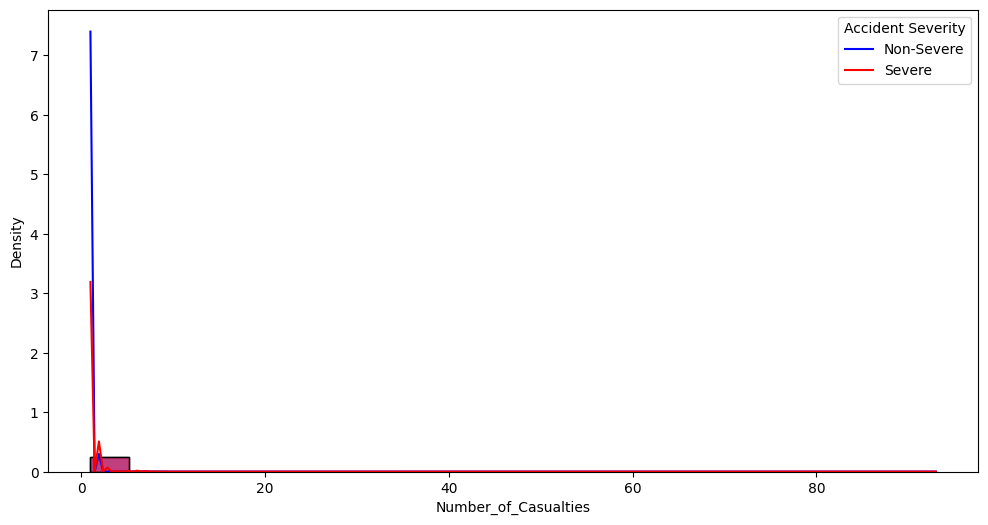

In [106]:
plt.figure(figsize=(12, 6))
sns.histplot(data = df, x = 'Number_of_Casualties', hue = 'Accident_Severity', kde = True, stat = 'density', common_norm = False, palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.legend(title = 'Accident Severity', labels = ['Non-Severe', 'Severe'])

* Observation: The majority number of casualties involved in accidents is one (77.01%), but the severity seems less severe. Higher casualities involved in accident (greater than 4) are rare (less than 5%) but likely severe.
* Action: keep it unchanged.

### Distribution of Number_of_Vehicles

In [107]:
df['Number_of_Vehicles'].value_counts(normalize = True)

Number_of_Vehicles
2     5.955533e-01
1     3.016584e-01
3     7.987228e-02
4     1.712878e-02
5     3.816328e-03
6     1.168882e-03
7     4.220283e-04
8     1.934296e-04
9     8.645719e-05
10    4.396128e-05
11    1.807297e-05
12    1.025763e-05
13    6.838422e-06
14    6.838422e-06
16    3.907670e-06
15    1.953835e-06
18    1.465376e-06
20    9.769174e-07
19    9.769174e-07
37    4.884587e-07
34    4.884587e-07
21    4.884587e-07
67    4.884587e-07
17    4.884587e-07
29    4.884587e-07
32    4.884587e-07
28    4.884587e-07
22    4.884587e-07
23    4.884587e-07
Name: proportion, dtype: float64

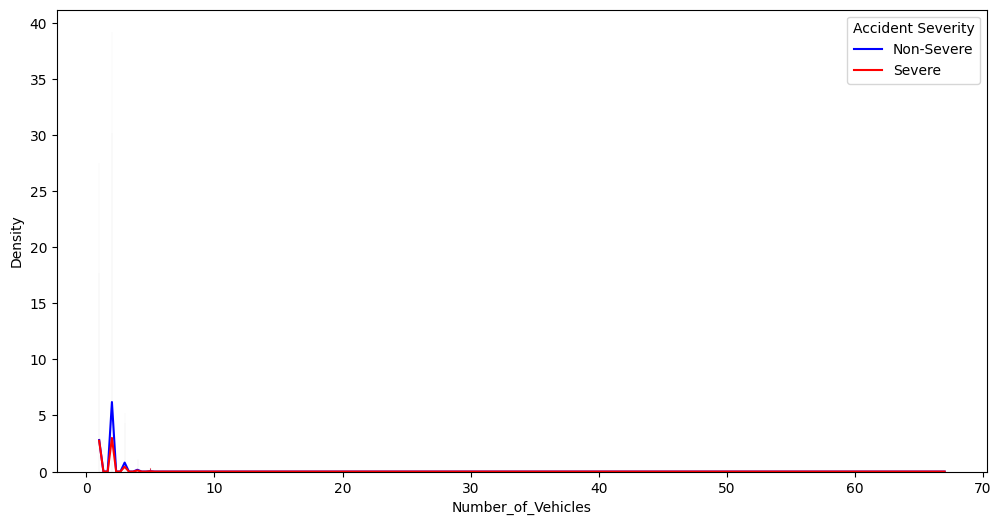

In [108]:
plt.figure(figsize=(12, 6))
sns.histplot(data = df, x = 'Number_of_Vehicles', hue = 'Accident_Severity', kde = True, stat = "density", common_norm = False, palette = {'Severe': 'red', 'Non-severe': 'blue'})
plt.legend(title = 'Accident Severity', labels = ['Non-Severe', 'Severe'])

* Observation: Most accidents involved 2 vehicles (59.56%), but they have low severity risk. The second highest number of accidents recored involved a single vehicle (30.17%), which shows a high severity risk. Accidents involved more vehicles (greater than 4) are rare (less than 1%) but tend to be severe.
* Action: Keep it unchanged.

### Heatmap of correlation between numerical features

<Axes: >

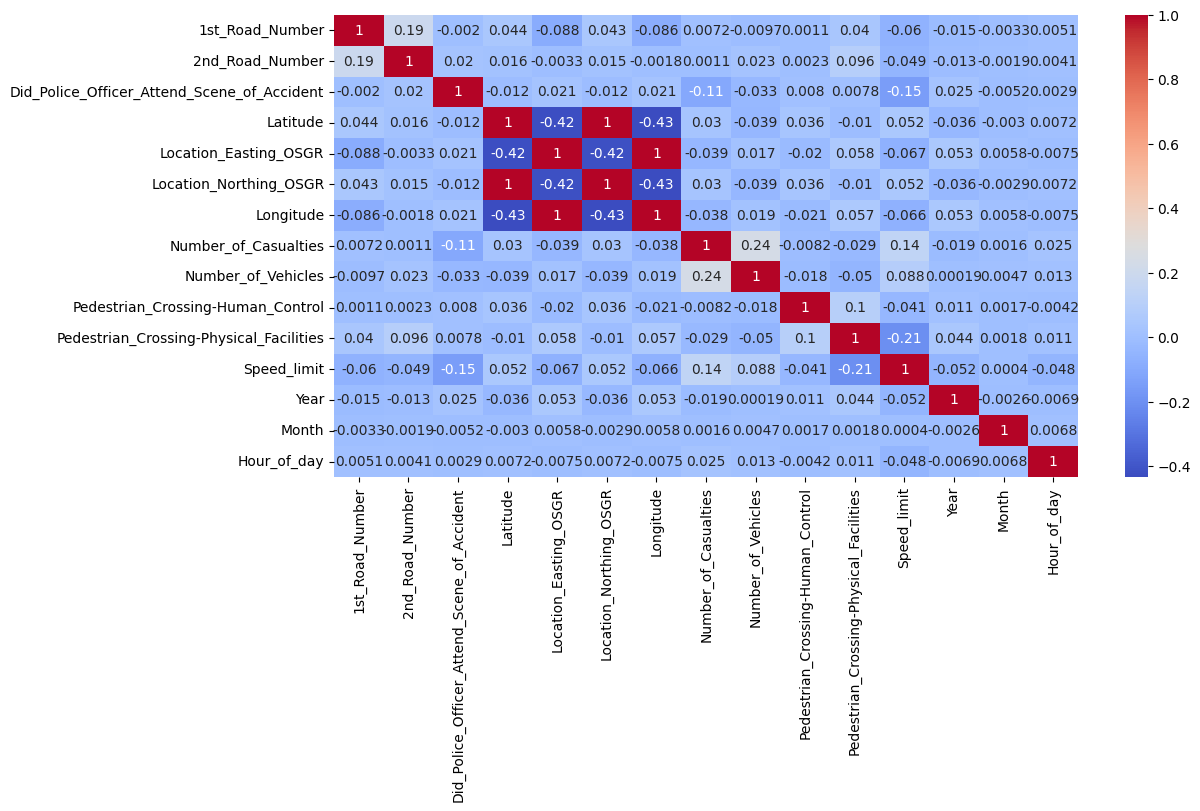

In [109]:
plt.figure(figsize = (12,6))
corr = df.corr(numeric_only = True)
sns.heatmap(corr, annot = True, cmap = 'coolwarm')

## Data pre-processing

### Drop useless features

In [110]:
df_new = df.copy()
df_new.drop(['Carriageway_Hazards', 'Date', 'Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location', 'Police_Force', 'Time', 'Year', 'Special_Conditions_at_Site', '2nd_Road_Number', '2nd_Road_Class'], axis = 1, inplace = True)

### Store features in vector X and target in vector y

In [111]:
X = df_new.drop('Accident_Severity', axis = 1)
y = df_new['Accident_Severity']

### Split data into training and test sets

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

### Impute missing values

In [113]:
# Impute missing values for the training set
X_train['1st_Road_Number'] = X_train['1st_Road_Number'].fillna(X_train['1st_Road_Number'].median())
X_train['Did_Police_Officer_Attend_Scene_of_Accident'] = X_train['Did_Police_Officer_Attend_Scene_of_Accident'].fillna(X_train['Did_Police_Officer_Attend_Scene_of_Accident'].median())
X_train['Latitude'] = X_train['Latitude'].fillna(X_train['Latitude'].median())
X_train['Location_Easting_OSGR'] = X_train['Location_Easting_OSGR'].fillna(X_train['Location_Easting_OSGR'].median())
X_train['Location_Northing_OSGR'] = X_train['Location_Northing_OSGR'].fillna(X_train['Location_Northing_OSGR'].median())
X_train['Longitude'] = X_train['Longitude'].fillna(X_train['Longitude'].median())
X_train['Pedestrian_Crossing-Human_Control'] = X_train['Pedestrian_Crossing-Human_Control'].fillna(X_train['Pedestrian_Crossing-Human_Control'].median())
X_train['Pedestrian_Crossing-Physical_Facilities'] = X_train['Pedestrian_Crossing-Physical_Facilities'].fillna(X_train['Pedestrian_Crossing-Physical_Facilities'].median())
X_train['Speed_limit'] = X_train['Speed_limit'].fillna(X_train['Speed_limit'].median())
X_train['Hour_of_day'] = X_train['Hour_of_day'].fillna(X_train['Hour_of_day'].median())
X_train['InScotland'] = X_train['InScotland'].fillna('Unknown')

In [114]:
# Impute missing values for test set
X_test['1st_Road_Number'] = X_test['1st_Road_Number'].fillna(X_train['1st_Road_Number'].median())
X_test['Did_Police_Officer_Attend_Scene_of_Accident'] = X_test['Did_Police_Officer_Attend_Scene_of_Accident'].fillna(X_train['Did_Police_Officer_Attend_Scene_of_Accident'].median())
X_test['Latitude'] = X_test['Latitude'].fillna(X_train['Latitude'].median())
X_test['Location_Easting_OSGR'] = X_test['Location_Easting_OSGR'].fillna(X_train['Location_Easting_OSGR'].median())
X_test['Location_Northing_OSGR'] = X_test['Location_Northing_OSGR'].fillna(X_train['Location_Northing_OSGR'].median())
X_test['Longitude'] = X_test['Longitude'].fillna(X_train['Longitude'].median())
X_test['Pedestrian_Crossing-Human_Control'] = X_test['Pedestrian_Crossing-Human_Control'].fillna(X_train['Pedestrian_Crossing-Human_Control'].median())
X_test['Pedestrian_Crossing-Physical_Facilities'] = X_test['Pedestrian_Crossing-Physical_Facilities'].fillna(X_train['Pedestrian_Crossing-Physical_Facilities'].median())
X_test['Speed_limit'] = X_test['Speed_limit'].fillna(X_train['Speed_limit'].median())
X_test['Hour_of_day'] = X_test['Hour_of_day'].fillna(X_train['Hour_of_day'].median())
X_test['InScotland'] = X_test['InScotland'].fillna('Unknown')

### Label encoding of the target variable by assigning 0 to Non-severe and 1 to Severe

In [115]:
y_train = y_train.replace(['Non-severe', 'Severe'], [0, 1])
y_test = y_test.replace(['Non-severe', 'Severe'], [0, 1])

### Label Encoding of categorical features by using OrdinalEncoder

In [116]:
# Define categorical features 
cat_features = ['1st_Road_Class', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions', 'Road_Surface_Conditions', 'Road_Type', 'Urban_or_Rural_Area', 'InScotland', 'High_winds', 'Weather_Conditions']

In [117]:
# Initialize OrdinalEncoder
lb_encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)

# Fit on the training data and then transform it
X_train[cat_features] = lb_encoder.fit_transform(X_train[cat_features].astype(str))

# Transform test data
X_test[cat_features] = lb_encoder.transform(X_test[cat_features].astype(str))

### Feature Selection by using SelectKBest method

In [118]:
# Initialize SelectKBest 
fs = SelectKBest(score_func = f_classif, k = 10)

# Fit on the training data and then transform it
X_train_new = fs.fit_transform(X_train, y_train)

# Transform test data
X_test_new = fs.transform(X_test)

In [119]:
# Selected features
selected_features = X_train.columns[fs.get_support()]
selected_features

Index(['Did_Police_Officer_Attend_Scene_of_Accident', 'Junction_Detail',
       'Latitude', 'Light_Conditions', 'Location_Northing_OSGR',
       'Number_of_Casualties', 'Number_of_Vehicles', 'Road_Type',
       'Speed_limit', 'Urban_or_Rural_Area'],
      dtype='object')

In [120]:
# Feature scores
feature_scores = pd.DataFrame({'features': X_train.columns, 'scores': fs.scores_})

# Selected features and their scores
feature_scores.nlargest(10, 'scores')

,features,scores
3,Did_Police_Officer_Attend_Scene_of_Accident,17420.534033
12,Number_of_Vehicles,9487.061992
18,Urban_or_Rural_Area,7750.485425
11,Number_of_Casualties,6870.353469
17,Speed_limit,6239.335847
7,Light_Conditions,4561.621845
5,Junction_Detail,3315.499584
9,Location_Northing_OSGR,1445.943899
6,Latitude,1443.556745
16,Road_Type,1273.405909


<Axes: xlabel='scores', ylabel='features'>

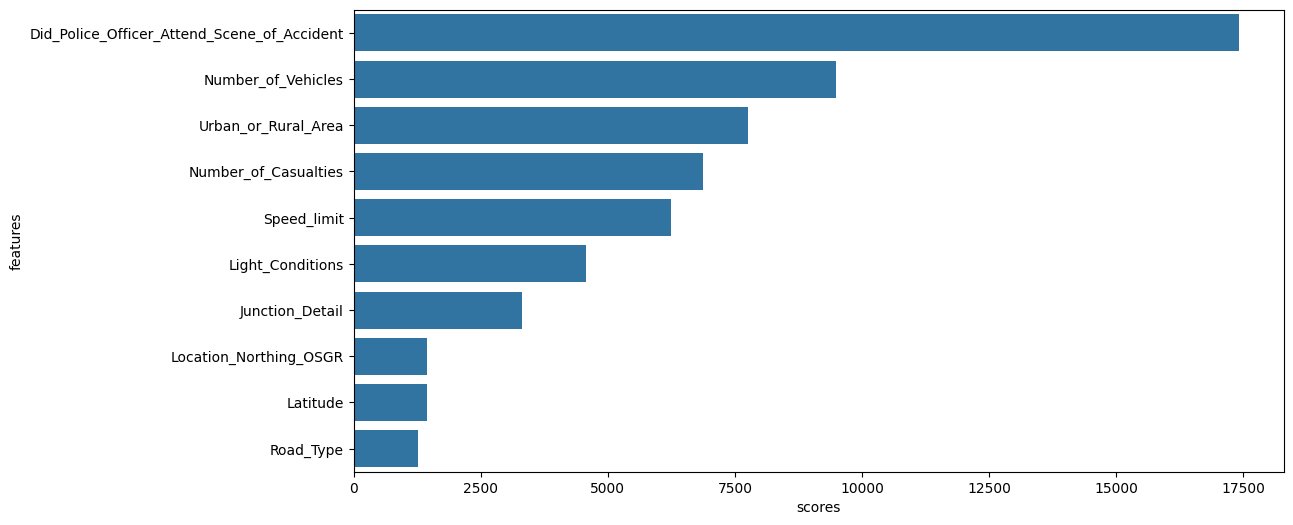

In [121]:
# Visualize feature importances
plt.figure(figsize = (12,6))
sns.barplot(data = feature_scores.nlargest(10, 'scores'), x = 'scores', y = 'features')

### Apply SMOTENC to handel imbalanced dataset

In [122]:
# Check class balance before SMOTENC
print(f'Class balance before SMOTENC: {Counter(y_train)}')

Class balance before SMOTENC: Counter({0: 1214183, 1: 218896})


In [123]:
# List selected categorical features
selected_cat_features = ['Junction_Detail', 'Light_Conditions', 'Road_Type', 'Urban_or_Rural_Area']

# Get indices of categorical features
cat_indices = [selected_features.get_loc(col) for col in selected_cat_features]
cat_indices

[1, 3, 7, 9]

In [124]:
# Initialize SMOTE-NC 
smote_nc = SMOTENC(categorical_features = cat_indices, random_state = 42)

# Apply SMOTENC on training data
X_train_res, y_train_res = smote_nc.fit_resample(X_train_new, y_train)

In [125]:
# Check class balance after SMOTENC
print(f'Class balance after SMOTENC: {Counter(y_train_res)}')

Class balance after SMOTENC: Counter({0: 1214183, 1: 1214183})


### Feature Scaling

In [127]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on the resampled data and then transform
X_train_res_scaled = scaler.fit_transform(X_train_res)

# Apply the same training data statistics on the test set
X_test_res_scaled = scaler.transform(X_test_new)

## Logistic Regression Model

In [145]:
# Create an instance of LogisticRegression
log_model = LogisticRegression(penalty = 'l2', C = 0.01, random_state = 42)

# Fit the model on the training set
log_model.fit(X_train_res_scaled, y_train_res)

# Predict on training data
y_train_pred = log_model.predict(X_train_res_scaled)

# Predict on test data
y_test_pred = log_model.predict(X_test_res_scaled)

In [146]:
print(f'Classification report for training set: {classification_report(y_train_res, y_train_pred)}')
print(f'Classification report for test set: {classification_report(y_test, y_test_pred)}')

Classification report for training set:               precision    recall  f1-score   support

           0       0.65      0.59      0.62   1214183
           1       0.63      0.69      0.65   1214183

    accuracy                           0.64   2428366
   macro avg       0.64      0.64      0.64   2428366
weighted avg       0.64      0.64      0.64   2428366

Classification report for test set:               precision    recall  f1-score   support

           0       0.89      0.59      0.71    520365
           1       0.20      0.58      0.30     93812

    accuracy                           0.59    614177
   macro avg       0.54      0.58      0.51    614177
weighted avg       0.78      0.59      0.65    614177



Confusion matrix for training set: [[719027 495156]
 [382464 831719]]


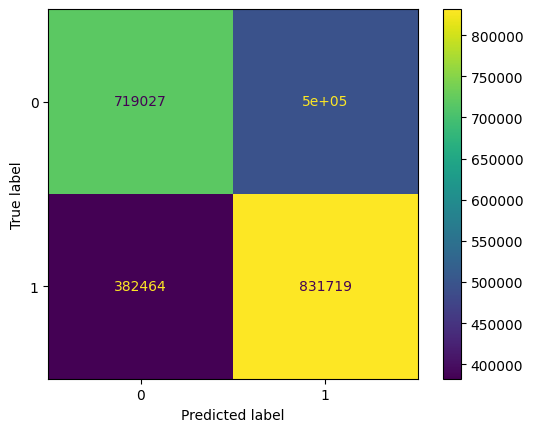

In [149]:
cm = confusion_matrix(y_train_res, y_train_pred)
print(f'Confusion matrix for training set: {cm}')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Confusion matrix for test set: [[308371 211994]
 [ 39677  54135]]


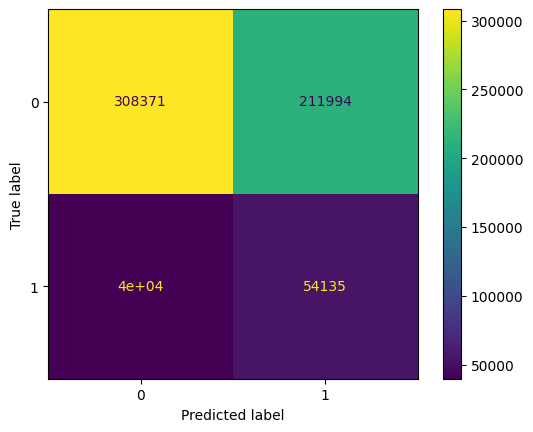

In [150]:
cm = confusion_matrix(y_test, y_test_pred)
print(f'Confusion matrix for test set: {cm}')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

The model performs reasonably well on the training set for both classes with an F1-score of 0.65 for 'Severe' class and 0.62 for 'Non-severe' class.

However, the model fails to generalize well in capturing 'Severe' accidents. In the test set, 'Non-severe' is the majority class with 520464 cases while 'Severe' only accounts for 93713. As a result, accuracy is misleading. The model is biased toward the Non-severe class with a high precision (0.89) and a decent recall (0.59), resulting a reasonably good F1-score (0.79) that balances the precision and recall. On the other hand, the model struggles with 'Severe' class with a low F1-score (0.30). While the recall is acceptable (0.58), the precision is very low (0.20), indicating a significant numbers of FP. This suggests that the model does not effectively identify 'Severe' case in unseen, unbalanced data.

## Random Forest

In [151]:
# Initialize RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100, min_samples_split= 200 , max_depth = 7, random_state = 42)
# Fit on the training set
rfc.fit(X_train_res, y_train_res)

# Predict on the training set
y_train_pred = rfc.predict(X_train_res)

# Predict on the test set
y_test_pred = rfc.predict(X_test_new)

In [152]:
print(f'Classification report for training set: {classification_report(y_train_res, y_train_pred)}')
print(f'Classification report for test set: {classification_report(y_test, y_test_pred)}')

Classification report for training set:               precision    recall  f1-score   support

           0       0.78      0.83      0.80   1214183
           1       0.82      0.76      0.79   1214183

    accuracy                           0.80   2428366
   macro avg       0.80      0.80      0.80   2428366
weighted avg       0.80      0.80      0.80   2428366

Classification report for test set:               precision    recall  f1-score   support

           0       0.87      0.83      0.85    520365
           1       0.26      0.33      0.29     93812

    accuracy                           0.75    614177
   macro avg       0.57      0.58      0.57    614177
weighted avg       0.78      0.75      0.77    614177



Confusion matrix for training set: [[1006624  207559]
 [ 286521  927662]]


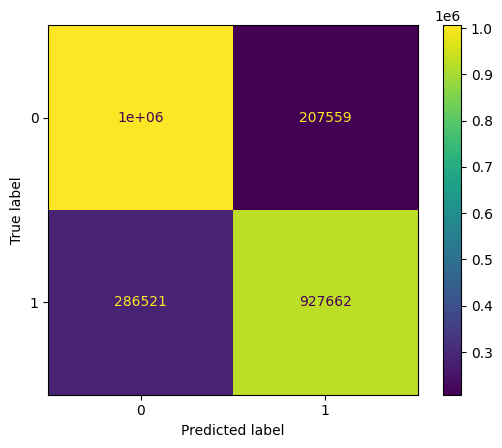

In [153]:
cm = confusion_matrix(y_train_res, y_train_pred)
print(f'Confusion matrix for training set: {cm}')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Confusion matrix for test set: [[431578  88787]
 [ 62693  31119]]


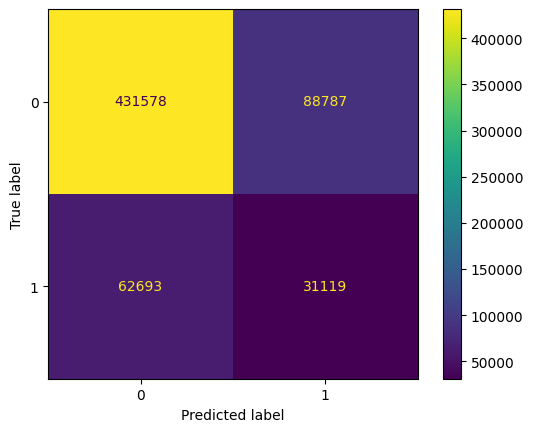

In [154]:
cm = confusion_matrix(y_test, y_test_pred)
print(f'Confusion matrix for test set: {cm}')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

The model shows a well performace on the training set for both classes, with an F1-score of 0.79 for 'Severe' class and 0.8 for 'Non-severe' class.

However, the model struggles to generalize well in identifying 'Severe' class. The model performs well in predicting the 'Non-severe' class with a 
high precision (0.87) and a high recall (0.83), which results in a high F1-score (0.85) that strongly balances between presicion and recall. On the other hand, the model has a very poor performance in predicting 'Severe' class as both the precision (0.26) and recall (0.33) are very low. This is due to a considerable numbers of FN and FP, leading to a very low F1-score (0.29). 

## XGBoost

In [155]:
# Use 80% to train and 20% to evaluate
n = int(len(X_train_res)*0.8)

X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train_res[:n], X_train_res[n:], y_train_res[:n], y_train_res[n:]

xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 7, verbosity = 1, early_stopping_rounds = 50, random_state = 42)
xgb_model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)])

[0]	validation_0-logloss:0.87923
[1]	validation_0-logloss:0.80229
[2]	validation_0-logloss:0.74177
[3]	validation_0-logloss:0.69268
[4]	validation_0-logloss:0.65195
[5]	validation_0-logloss:0.61741
[6]	validation_0-logloss:0.58628
[7]	validation_0-logloss:0.56203
[8]	validation_0-logloss:0.53909
[9]	validation_0-logloss:0.51762
[10]	validation_0-logloss:0.49938
[11]	validation_0-logloss:0.48303
[12]	validation_0-logloss:0.46935
[13]	validation_0-logloss:0.45651
[14]	validation_0-logloss:0.44263
[15]	validation_0-logloss:0.43352
[16]	validation_0-logloss:0.42432
[17]	validation_0-logloss:0.41663
[18]	validation_0-logloss:0.40750
[19]	validation_0-logloss:0.39995
[20]	validation_0-logloss:0.39279
[21]	validation_0-logloss:0.38705
[22]	validation_0-logloss:0.38179
[23]	validation_0-logloss:0.37594
[24]	validation_0-logloss:0.36938
[25]	validation_0-logloss:0.36240
[26]	validation_0-logloss:0.35788
[27]	validation_0-logloss:0.35430
[28]	validation_0-logloss:0.34686
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [156]:
# Predict on the training set
y_train_pred = xgb_model.predict(X_train_res)

# Predict on the test set
y_test_pred = xgb_model.predict(X_test_new)

print(f'Classification report for training set: {classification_report(y_train_res, y_train_pred)}')
print(f'Classification report for test set: {classification_report(y_test, y_test_pred)}')

Classification report for training set:               precision    recall  f1-score   support

           0       0.75      0.99      0.85   1214183
           1       0.99      0.66      0.79   1214183

    accuracy                           0.83   2428366
   macro avg       0.87      0.83      0.82   2428366
weighted avg       0.87      0.83      0.82   2428366

Classification report for test set:               precision    recall  f1-score   support

           0       0.85      0.99      0.92    520365
           1       0.42      0.03      0.05     93812

    accuracy                           0.85    614177
   macro avg       0.64      0.51      0.48    614177
weighted avg       0.79      0.85      0.78    614177



Confusion matrix for training set: [[1206898    7285]
 [ 408618  805565]]


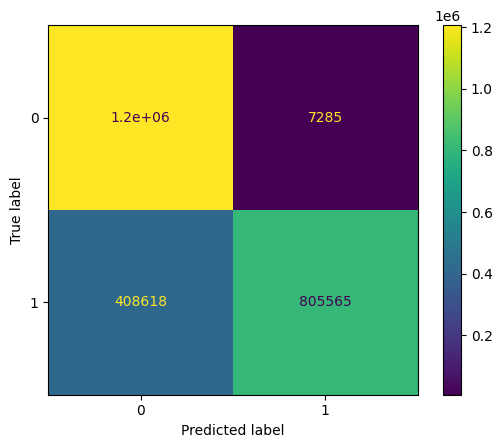

In [160]:
cm = confusion_matrix(y_train_res, y_train_pred)
print(f'Confusion matrix for training set: {cm}')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Confusion matrix for test set: [[516955   3410]
 [ 91292   2520]]


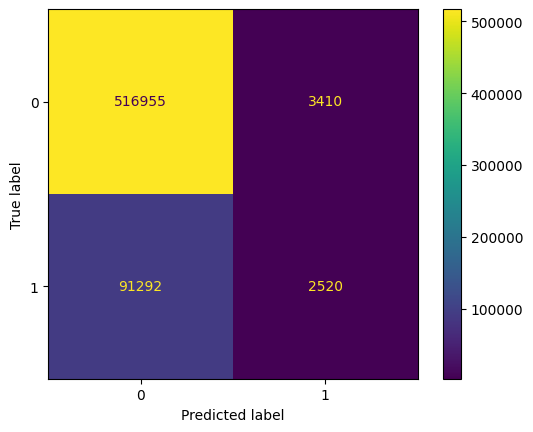

In [162]:
cm = confusion_matrix(y_test, y_test_pred)
print(f'Confusion matrix for test set: {cm}')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

The model performs well on the training set with an F1-score of 0.85 for 'Non-severe' class and 0.79 for 'Severe' class. However, it fails to generalize to 'Severe' class in the test set.While it maintains a high F1-score of 0.92 for the majority ('Non-severe) class, its performance on the minority ('Severe') class is extremely poor. The recall is 0.03 and the precision is 0.42, resulting an extremly low F1-score of 0.05. This indicates that nearly all 'Severe' cases are misclassified as 'Non-severe'. 

## Challenges
* Feature overlap

The predictive features, including the most significant features selected by the SelectKBest, have a minimal distinction between the 'Severe' and 'Non-severe' classes. 
* Class Imbalace

The dataset is highly unbalanced with 85%  of the data classified as 'Non-severe' and only 15% as 'Severe'.  This imbalance causes models to bias the 'Non-severe' class, resulting in poor precision or recall for 'Severe' class.
* Models have high variance (overfitting)

Logistic Regression, Random Forest, and XGBoost models showes high variance and failed to generalization in capturing the minority class ('Severe'), even after feature selection and resampling.

## Future direction
* Hyperparameter tuning and cross-validation
* Collect more data examples

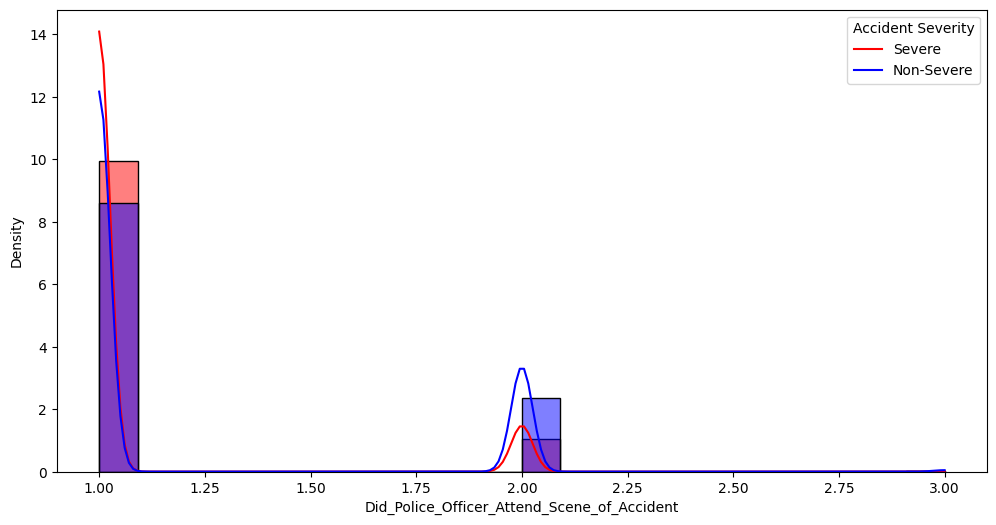

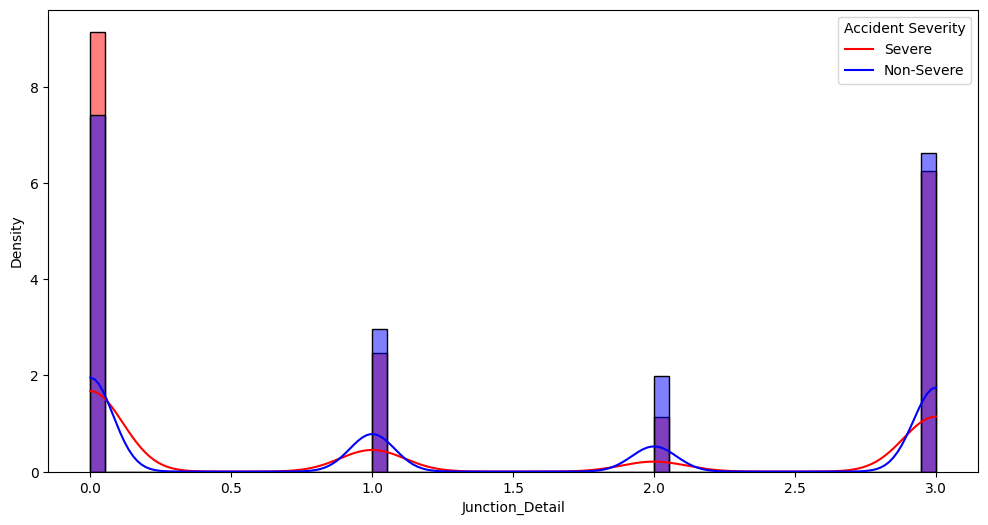

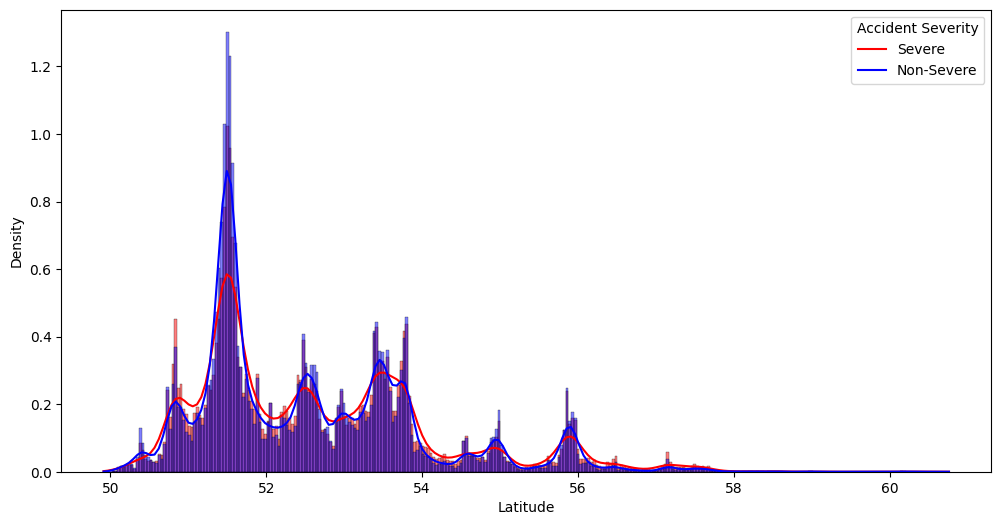

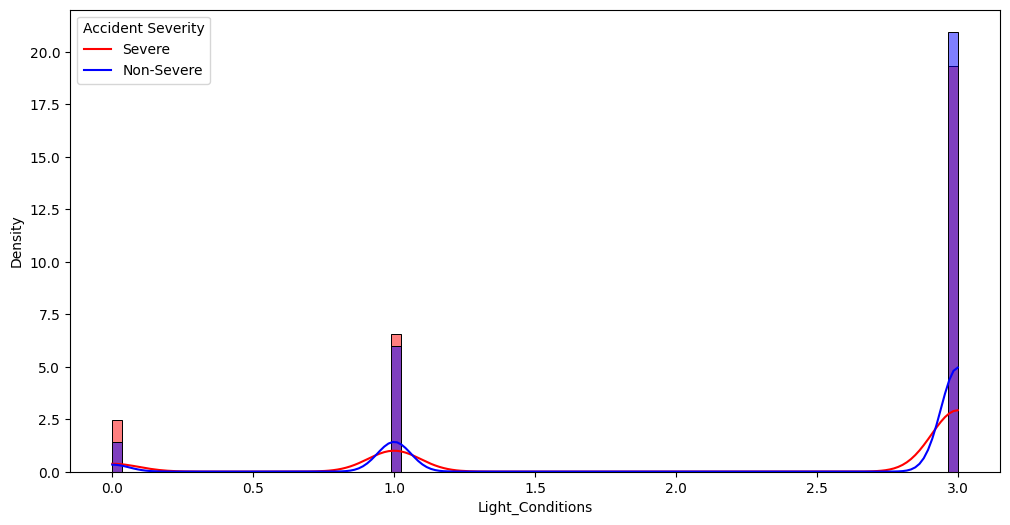

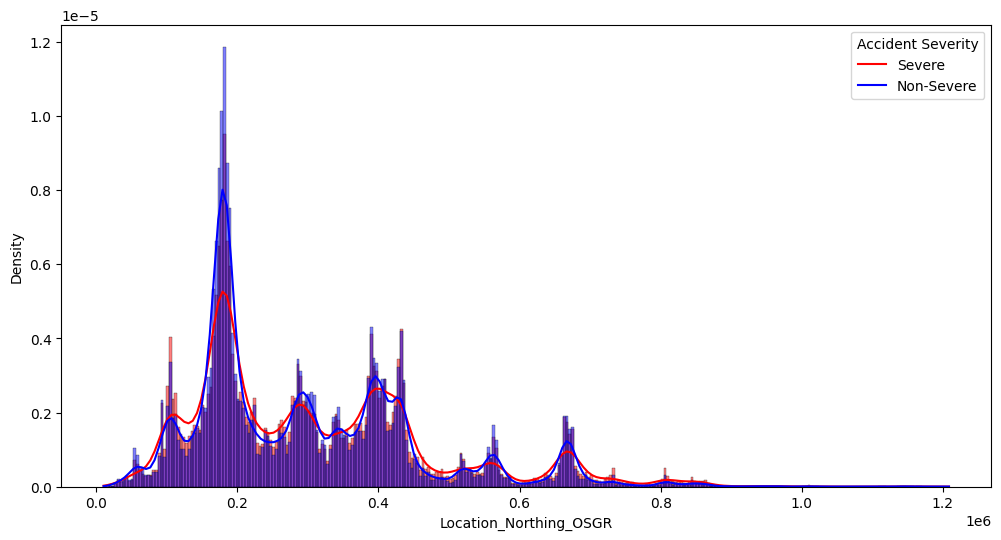

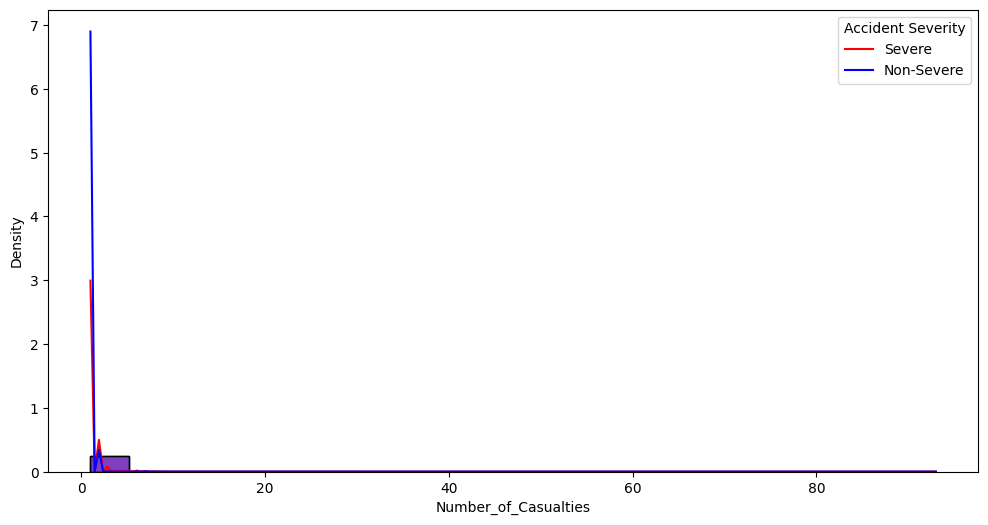

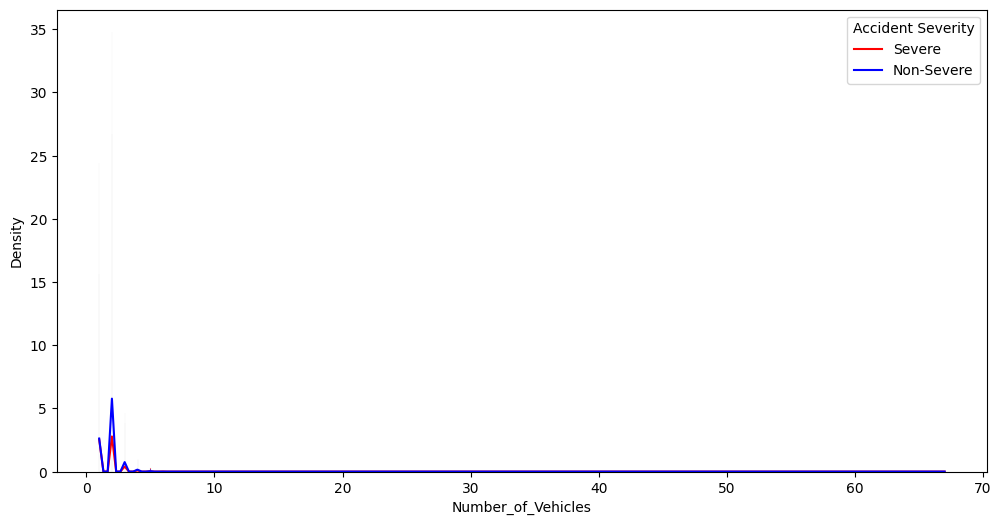

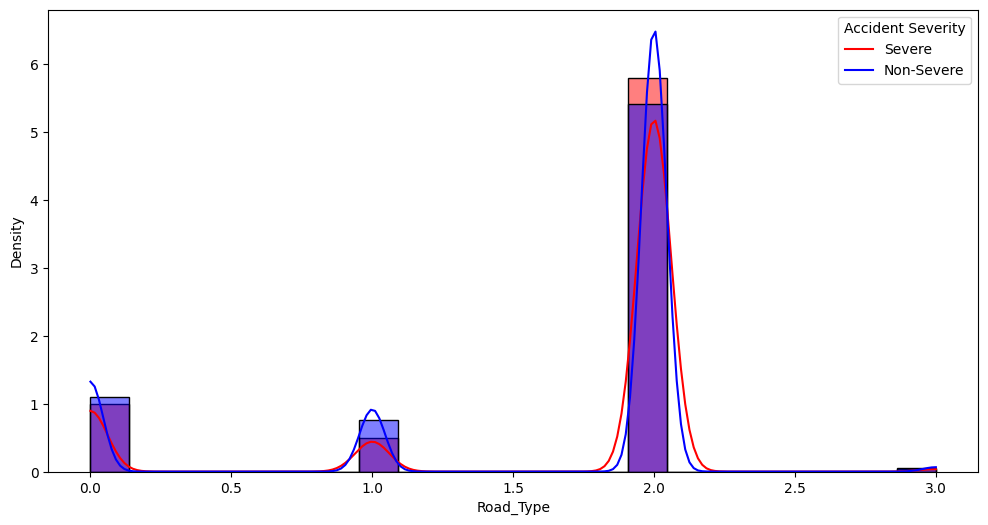

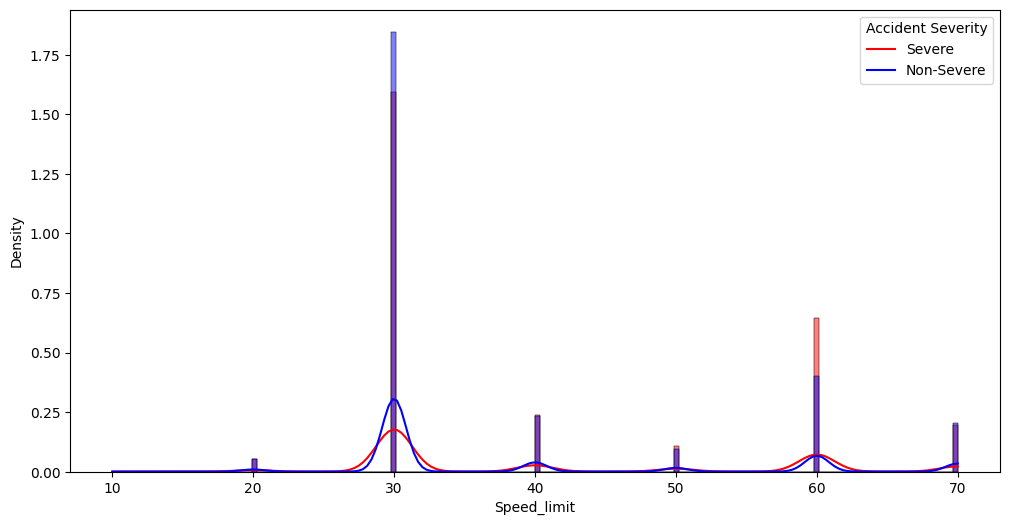

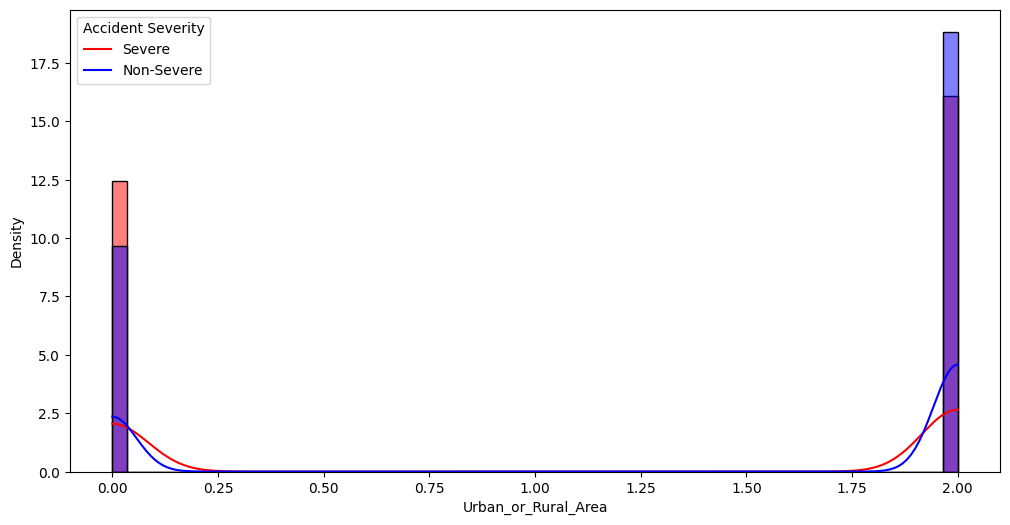

In [190]:
train_data = X_train.copy()
train_data['Accident_Severity'] = y_train
train_data['Accident_Severity'] = train_data['Accident_Severity'].replace([0, 1],['Non-severe', 'Severe'])

for feat in selected_features:
    plt.figure(figsize=(12, 6))
    sns.histplot(data = train_data, x = feat, hue = 'Accident_Severity', kde = True, stat = "density", common_norm = False, palette = {'Severe': 'red', 'Non-severe': 'blue'})
    plt.legend(title = 'Accident Severity', labels = ['Severe', 'Non-Severe'])